In [3]:
import networkx as nx
#from mia import MIA
import networkx.algorithms.community as nxcom
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tqdm
import time as time


In [9]:
pb2018 = nx.read_gml('/Users/davidguzman/Documents/GitHub/Network-Science-final-Maximization-/Proud_Boys_Datsets/PB2018.gml')

In [10]:
pb2020 = nx.read_gml('/Users/davidguzman/Documents/GitHub/Network-Science-final-Maximization-/Proud_Boys_Datsets/PB2020.gml')

In [11]:
# comapare the two graphs
print('PB2018 has {} nodes and {} edges'.format(pb2018.number_of_nodes(), pb2018.number_of_edges()))
print('PB2020 has {} nodes and {} edges'.format(pb2020.number_of_nodes(), pb2020.number_of_edges()))

PB2018 has 42988 nodes and 85670 edges
PB2020 has 13217 nodes and 14477 edges


In [12]:
# are they weighted?
print('PB2018 is weighted: {}'.format(nx.is_weighted(pb2018)))
print('PB2020 is weighted: {}'.format(nx.is_weighted(pb2020)))

PB2018 is weighted: True
PB2020 is weighted: True


In [13]:
#print unique weight values of PB2018
print('Unique weight values of PB2018: {}'.format(np.unique([pb2018[u][v]['weight'] for u,v in pb2018.edges()])))

Unique weight values of PB2018: [ 1 10]


In [14]:
#print unique weight values of PB2020
print('Unique weight values of PB2020: {}'.format(np.unique([pb2020[u][v]['weight'] for u,v in pb2020.edges()])))

Unique weight values of PB2020: [ 1 10]


In [8]:
#invert edge direction for PB2020 and PB2018
pb2018 = pb2018.reverse()
pb2020 = pb2020.reverse()

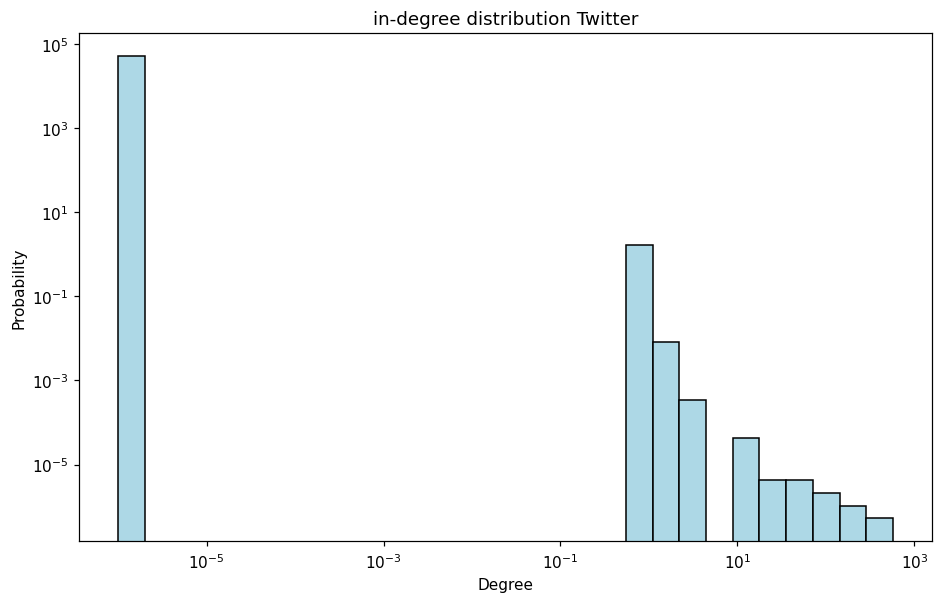

In [8]:
#print in-degree distribution for pb2020
deg = [d for n, d in pb2020.out_degree()] # we use out degree because they inverted the direction of the edges
# replace 0 values with 0.000001
deg = [0.000001 if x == 0 else x for x in deg]
plt.figure(figsize=(10,6), dpi=110)
my_bins = np.logspace(np.log10(min(deg)),np.log10(max(deg) +1), 30 ) 
plt.hist(deg, bins=my_bins, density = True, color = "lightblue", ec="black")
plt.title("in-degree distribution Twitter")
plt.ylabel("Probability")
plt.xlabel("Degree") 
plt.xscale('log')
plt.yscale('log')
plt.show()

### Greedy community detection for execution time reduction: (turns out to be a bad idea)

In [119]:
pb20_comms = nxcom.greedy_modularity_communities(pb2020)

In [121]:
#print number of communities
print('PB2020 has {} communities'.format(len(list(pb20_comms))))
#print the size of each community
for i, comm in enumerate(pb20_comms):
    print('Community {} has {} nodes'.format(i, len(comm)))

PB2020 has 13 communities
Community 0 has 4390 nodes
Community 1 has 3738 nodes
Community 2 has 1429 nodes
Community 3 has 885 nodes
Community 4 has 858 nodes
Community 5 has 534 nodes
Community 6 has 405 nodes
Community 7 has 393 nodes
Community 8 has 208 nodes
Community 9 has 187 nodes
Community 10 has 103 nodes
Community 11 has 84 nodes
Community 12 has 3 nodes


In [122]:
#save the subgraph of each community to a list 
pb20_comms_subgraphs = []
for comm in pb20_comms:
    pb20_comms_subgraphs.append(pb2020.subgraph(comm))

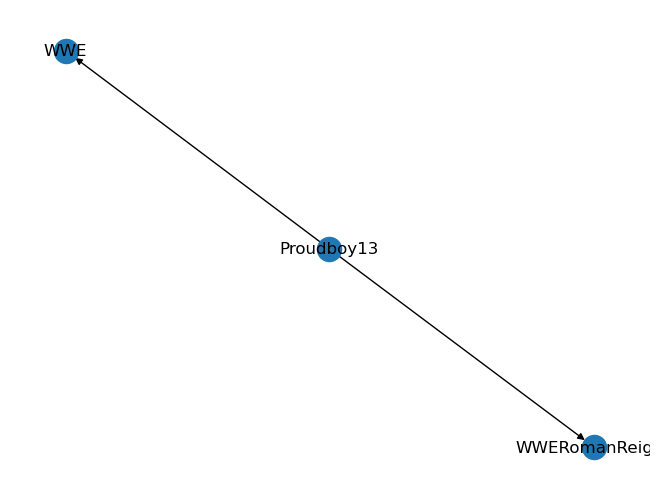

In [123]:
#plt.figure(figsize=(40,40))
nx.draw(pb20_comms_subgraphs[12], with_labels=True)

the problem with this community mmechanism is that most nodes in a community end up having the same degree!! so it does not make sense to use the MIA on it 

### Back to the original dataset

In [9]:
# overwrite the weights in pb20_comms_subgraphs[12] as q/in-degree of the node for the outgoing edges of said node, where q=1
test_pb20_comms = pb2020.copy()
for edge in test_pb20_comms.edges():
    if test_pb20_comms.in_degree(edge[0]) == 0: # to avoid division by 0
        #test_pb20_comms[edge[0]][edge[1]]['weight'] = np.abs(np.log(0.00000001))
        test_pb20_comms[edge[0]][edge[1]]['weight'] = 0
    else:
        #test_pb20_comms[edge[0]][edge[1]]['weight'] = np.abs(np.log(1/test_pb20_comms.in_degree(edge[1])))
        test_pb20_comms[edge[0]][edge[1]]['weight'] = 1/test_pb20_comms.in_degree(edge[1])


In [10]:
# print unique weights 
print(np.unique([test_pb20_comms[edge[0]][edge[1]]['weight'] for edge in test_pb20_comms.edges()]))


[0.00000000e+00 2.29042602e-04 2.63088661e-04 7.01262272e-04
 1.12866817e-03 1.65562914e-03 1.94552529e-03 5.12820513e-03
 5.34759358e-03 5.61797753e-03 5.98802395e-03 8.54700855e-03
 9.43396226e-03 2.12765957e-02 2.38095238e-02 4.34782609e-02
 8.33333333e-02 1.00000000e-01 1.11111111e-01 1.66666667e-01
 2.50000000e-01 3.33333333e-01 5.00000000e-01 1.00000000e+00]


In [134]:
#TODO weights must become log probabilities so that it makes sense to use djisktra on them (shortest path as sum of weights, sum of logs as joint log probability)

In [43]:
mir_pairs_global = dict(nx.all_pairs_dijkstra(test_pb20_comms, weight='weight'))

In [132]:
from copy import deepcopy
import networkx as ntwx
import numpy as np
import pandas as pd
import random
from itertools import combinations
import matplotlib.pyplot as plt
from tqdm import tqdm

# greatly optimized version of the python implementation proposed by https://github.com/ksasi/fairMIA

def getpp(network, w, u):
    """Returns path propagation probability"""
    pp = 1
    #path = ntwx.dijkstra_path(network, w, u, weight = 'weight')
    path = mir_pairs_global[w][1][u]
    edges = list(ntwx.utils.misc.pairwise(path))
    for edge in edges:
        #print(network[edge[0]][edge[1]]['weight'])
        pp = pp*network[edge[0]][edge[1]]['weight']
    return pp


def getMIIA(graph, v, theta, digraph = True):
    "Returns MAXIMUM INFLUENCE IN-ARBORESCENCE"
    #nodes = list(dgraph.nodes())
    #print('hello getMIIA')
    if digraph == True:
      miia = ntwx.DiGraph()
    else:
      miia = ntwx.Graph()
    startdijkstra = time.time()
    mir_pairs = dict(ntwx.all_pairs_dijkstra(graph, weight='weight')) # why do you do this every single time?? could we not just do it once and then pass it to the function?
    enddijkstra = time.time()
    #print('dijkstra took {} seconds'.format(enddijkstra - startdijkstra))
    for val in mir_pairs.values():
        #print(val[1].values())
        if v in val[1].keys():
            #print(v)
            pp = getpp(graph, val[1][v][0], val[1][v][-1])
            if pp > theta:
                edges = list(ntwx.utils.misc.pairwise(val[1][v]))
                miia.add_edges_from(edges)
                #miia.add_nodes_from(val[1][v])
                #ntwx.draw(miia)
    for edge in miia.edges():
      miia[edge[0]][edge[1]]['weight'] = graph[edge[0]][edge[1]]['weight']
    #print('goodbye getMIIA')
    return miia

def getMIIA_global(graph, v, theta, digraph = True):
    "Returns MAXIMUM INFLUENCE IN-ARBORESCENCE"
    #nodes = list(dgraph.nodes())
    #print('hello getMIIA')
    if digraph == True:
        miia = ntwx.DiGraph()
    else:
        miia = ntwx.Graph()
    #mir_pairs = dict(ntwx.all_pairs_dijkstra(graph, weight='weight')) # why do you do this every single time?? could we not just do it once and then pass it to the function?
    
    for val in mir_pairs_global.values():
        #print(val[1].values())
        if v in val[1].keys():
            #print(v)
            pp = getpp(graph, val[1][v][0], val[1][v][-1])
            if pp > theta:
                edges = list(ntwx.utils.misc.pairwise(val[1][v]))
                miia.add_edges_from(edges)
                #miia.add_nodes_from(val[1][v])
                #ntwx.draw(miia)
 
    for edge in miia.edges():
        miia[edge[0]][edge[1]]['weight'] = graph[edge[0]][edge[1]]['weight']
    #print('goodbye getMIIA')
   
    return miia

def getMIOA(graph, v, theta, digraph = True):
    "Returns MAXIMUM INFLUENCE OUT-ARBORESCENCE"
    if digraph == True:
      mioa = ntwx.DiGraph()
    else:
      mioa = ntwx.Graph()
    mir_pairs = dict(ntwx.all_pairs_dijkstra(graph, weight='weight'))
    if v in mir_pairs.keys():
        for val in mir_pairs[v][1].values():
            pp = getpp(graph, val[0], val[-1])
            if pp > theta:
                #print(val)
                edges = list(ntwx.utils.misc.pairwise(val))
                #print(edges)
                mioa.add_edges_from(edges)
                #ntwx.draw(mioa)
    for edge in mioa.edges():
      mioa[edge[0]][edge[1]]['weight'] = graph[edge[0]][edge[1]]['weight']
    return mioa


def getap(u, S, MIIA): #problematic
    """Returns activation probability given a note and MIIA"""
    #print('hello getap')
    if len(S) == 0:
        return 0
    if u in S :
        return 1
    elif len(list(MIIA.predecessors(u))) == 0:
        return 0
    else:
        ap = 1
        #print(list(MIIA.predecessors(u)))
        for w in list(MIIA.predecessors(u)):
            #print("Node:", w)
            ap = 1 - ap*(1 - getap(w, S, MIIA)*getpp(MIIA, w, u))
            #print(ap)
            #print("\n")
    #print('goodbye getap')
    return ap

def getallap(S, MIIA):
    """Returns a dictionary activation probabilities for all nodes in MIIA"""
    ap_dict = dict()
    node_nb_dict = dict()
    for n in MIIA.nodes():
      node_nb_dict[n] = len(list(MIIA.predecessors(n)))
    #temp = list(ntwx.topological_sort(MIIA))
    #print(temp)
    #print(node_nb_dict)
    #print(sorted(node_nb_dict, key=node_nb_dict.get))
    for u in list(ntwx.topological_sort(MIIA)):
        if u in S :
            ap_dict[u] = 1
        elif node_nb_dict[u] == 0:
            ap_dict[u] = 0
        else:
            ap = 1
            #print(list(MIIA.predecessors(u)))
            #print(u)
            #print(list(MIIA.predecessors(u)))
            for w in list(MIIA.predecessors(u)):
                #print("\n")
                #print("Node:", w)
                #print(node_nb_dict[w])
                ap = ap*(1 - ap_dict[w]*getpp(MIIA, w, u))
                #print(ap)
                #print("\n")
            ap_dict[u] = 1 - ap
    return ap_dict


def getalpha(v, u, S, network, theta): #super problematic
    """ Returns the value of aplha as per Algorithm3"""
    #print('hello getalpha')
    MIIA = getMIIA(network, v, theta, True)
    if v == u :
        return 1
    else:
        w = list(MIIA.successors(u))[0]
        if w in S :
            return 0
        else:
            alpha = getalpha(v, w, S, MIIA, theta)*getpp(MIIA, u, w)
            for u_dash in list(MIIA.predecessors(w)):
                alpha = alpha * (1 - getap(u_dash, S, MIIA)*getpp(MIIA, u_dash, w))
    #print('goodbye getalpha')
    return alpha



def MIA(network, k, theta):
    """MIA algorithm for influence maximization - Algorithm4"""
    S = []
    print("Starting MIA intialization")
    Incinf_dict = dict()
    ap_dict = dict()
    for v in list(network.nodes()):
        Incinf_dict[v] = 0
    for v in list(network.nodes()):
        startgetMIIA = time.time()
        MIIAv = getMIIA(network, v, theta, digraph = True)
        endgetMIIA = time.time()
        MIIA = MIIAv
        #MIOA = getMIOA(network, v, theta, digraph = True)
        #print(len(list(MIIA.nodes())))
        startforMIIA = time.time()
        for u in list(MIIA.nodes()):
            Incinf_dict[u] = Incinf_dict[u] + getalpha(v, u, S, MIIAv, theta) * (1 - getap(u, S, MIIA))
            #print(Incinf_dict[u])
        endforMIIA = time.time()
        #print("Time for getMIIA:", endgetMIIA - startgetMIIA)
        #print("Time for forMIIA:", endforMIIA - startforMIIA)

    print("Initialization Completed")
    for i in tqdm(range(1, k+1)):
        u = max(Incinf_dict, key = Incinf_dict.get)
        MIOA = getMIOA(network, u, theta, digraph = True)
        for v in list(MIOA.nodes()):
            MIIAv = getMIIA(network, v, theta, digraph = True)
            ap_all = getallap(S, MIIAv)
            for w in list(MIIAv.nodes()):
                Incinf_dict[w] = Incinf_dict[w] - getalpha(v, w, S, MIIAv, theta)*(1 - ap_all[w])
        S.append(u)
        #print(S)
        for v in tqdm(list(MIOA.nodes())):
            MIIAv = getMIIA(network, v, theta, digraph = True)
            ap_all = getallap(S, MIIAv)
            for w in list(MIIAv.nodes()):
                Incinf_dict[w] = Incinf_dict[w] + getalpha(v, w, S, MIIAv, theta)*(1 - ap_all[w])
    return S

def MIA_fast(network, k, theta):

    S = []
    print("Starting MIA intialization")
    Incinf_dict = dict()
    ap_dict = dict()
    for v in list(network.nodes()):
        Incinf_dict[v] = 0
    for v in tqdm(list(network.nodes())):
        MIIAv = getMIIA_global(network, v, theta, digraph = True)
        MIIA = MIIAv
        #MIOA = getMIOA(network, v, theta, digraph = True)
        #print(len(list(MIIA.nodes())))
        for u in list(MIIA.nodes()):
            Incinf_dict[u] = Incinf_dict[u] + getalpha(v, u, S, MIIAv, theta) * (1 - getap(u, S, MIIA))

    print("Initialization Completed")

    for i in tqdm(range(1, k+1)):
        u = max(Incinf_dict, key = Incinf_dict.get)
        MIOA = getMIOA(network, u, theta, digraph = True)
        for v in list(MIOA.nodes()):
            MIIAv = getMIIA_global(network, v, theta, digraph = True)
            ap_all = getallap(S, MIIAv)
            for w in list(MIIAv.nodes()):
                Incinf_dict[w] = Incinf_dict[w] - getalpha(v, w, S, MIIAv, theta)*(1 - ap_all[w])
        S.append(u)
        #print(S)
        for v in list(MIOA.nodes()):
            MIIAv = getMIIA_global(network, v, theta, digraph = True)
            ap_all = getallap(S, MIIAv)
            for w in list(MIIAv.nodes()):
                Incinf_dict[w] = Incinf_dict[w] + getalpha(v, w, S, MIIAv, theta)*(1 - ap_all[w])
    return S


In [133]:
MIA_fast(test_pb20_comms, 2, 0.5)

Starting MIA intialization


100%|██████████| 13217/13217 [00:42<00:00, 309.71it/s]


Initialization Completed


100%|██████████| 2/2 [00:27<00:00, 13.84s/it]


['enrique_tarrio',
 'GavinM_ProudBoy',
 'proudboy2012',
 'Premises187',
 'ProudBoysGBG',
 'principe_giovan',
 'MoralDK']